<a href="https://colab.research.google.com/github/antonioalbanese/Time-Series-Anomaly-Detection-An-experimental-survey/blob/main/Experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pytorch_lightning torchinfo --quiet

     |████████████████████████████████| 796 kB 26.6 MB/s 
     |████████████████████████████████| 136 kB 61.3 MB/s 
     |████████████████████████████████| 529 kB 73.5 MB/s 
     |████████████████████████████████| 87 kB 6.8 MB/s 


In [1]:
!git clone https://github.com/antonioalbanese/Time-Series-Anomaly-Detection-An-experimental-survey/

%cd Time-Series-Anomaly-Detection-An-experimental-survey

%mkdir dataset
!gdown https://drive.google.com/uc?id=1ZCLBU_pKTbsPlcj_LwxZE3IRy6mrlys3 -O="./dataset/MSL.zip"
!gdown https://drive.google.com/uc?id=18JNYBsaX7tu0Qfgo92nCBCklv471L1xB -O="./dataset/SMD.zip"
import zipfile
with zipfile.ZipFile("./dataset/MSL.zip", 'r') as zip_ref:
    zip_ref.extractall("./dataset/")
with zipfile.ZipFile("./dataset/SMD.zip", 'r') as zip_ref:
    zip_ref.extractall("./dataset/")

Cloning into 'Time-Series-Anomaly-Detection-An-experimental-survey'...
remote: Enumerating objects: 450, done.
remote: Counting objects: 100% (357/357), done.
remote: Compressing objects: 100% (233/233), done.
remote: Total 450 (delta 200), reused 211 (delta 121), pack-reused 93
Receiving objects: 100% (450/450), 2.66 MiB | 11.08 MiB/s, done.
Resolving deltas: 100% (212/212), done.
/content/Time-Series-Anomaly-Detection-An-experimental-survey
Downloading...
From: https://drive.google.com/uc?id=1ZCLBU_pKTbsPlcj_LwxZE3IRy6mrlys3
To: /content/Time-Series-Anomaly-Detection-An-experimental-survey/dataset/MSL.zip
100% 767k/767k [00:00<00:00, 145MB/s]
Downloading...
From: https://drive.google.com/uc?id=18JNYBsaX7tu0Qfgo92nCBCklv471L1xB
To: /content/Time-Series-Anomaly-Detection-An-experimental-survey/dataset/SMD.zip
100% 195M/195M [00:01<00:00, 173MB/s]


In [3]:
!mkdir input
#normal period
!python USAD/gdrivedl.py https://drive.google.com/open?id=1rVJ5ry5GG-ZZi5yI4x9lICB8VhErXwCw input/
#anomalies
!python USAD/gdrivedl.py https://drive.google.com/open?id=1iDYc0OEmidN712fquOBRFjln90SbpaE7 input/



input/SWaT_Dataset_Normal_v1.csv
[==================================================] 163.77MB/163.77MB
input/SWaT_Dataset_Attack_v0.csv
[==================================================] 127.27MB/127.27MB


In [4]:
from AnomalyDetectionMethodClass import ADMethod
settings={
    'EPOCHS':50,
    'BATCH_SIZE': 7919,
    'SEQ_LEN': 12,
    'HIDDEN_SIZE': 100}
data_path = ''
method = ADMethod('USAD',settings,'')

method.prepare_pipeline()
h = method.train()
r = method.test()

/content/Time-Series-Anomaly-Detection-An-experimental-survey/USAD/USADSolver.py:19: DtypeWarning: Columns (26) have mixed types.Specify dtype option on import or set low_memory=False.
  self.prepare_data()
/content/Time-Series-Anomaly-Detection-An-experimental-survey/USAD/USADSolver.py:19: DtypeWarning: Columns (1,9,28,46) have mixed types.Specify dtype option on import or set low_memory=False.
  self.prepare_data()


Epoch [0], val_loss1: 0.0259, val_loss2: 0.0258
Epoch [1], val_loss1: 0.0235, val_loss2: -0.0050
Epoch [2], val_loss1: 0.0261, val_loss2: -0.0145
Epoch [3], val_loss1: 0.0400, val_loss2: -0.0292
Epoch [4], val_loss1: 0.0401, val_loss2: -0.0335
Epoch [5], val_loss1: 0.0426, val_loss2: -0.0344
Epoch [6], val_loss1: 0.0429, val_loss2: -0.0387
Epoch [7], val_loss1: 0.0431, val_loss2: -0.0392
Epoch [8], val_loss1: 0.0784, val_loss2: -0.0635
Epoch [9], val_loss1: 0.0724, val_loss2: -0.0598
Epoch [10], val_loss1: 0.0723, val_loss2: -0.0620
Epoch [11], val_loss1: 0.0779, val_loss2: -0.0691
Epoch [12], val_loss1: 0.0746, val_loss2: -0.0675
Epoch [13], val_loss1: 0.0749, val_loss2: -0.0684
Epoch [14], val_loss1: 0.0750, val_loss2: -0.0690
Epoch [15], val_loss1: 0.0741, val_loss2: -0.0685
Epoch [16], val_loss1: 0.0745, val_loss2: -0.0692
Epoch [17], val_loss1: 0.0746, val_loss2: -0.0697
Epoch [18], val_loss1: 0.0750, val_loss2: -0.0703
Epoch [19], val_loss1: 0.0747, val_loss2: -0.0703
Epoch [20],

In [33]:
torch.cuda.empty_cache()

In [4]:
len(method.solver.test_labels)


449907

In [15]:
import torch
import numpy as np
y_pred=np.concatenate([torch.stack(r[:-1]).flatten().detach().cpu().numpy(),
                              r[-1].flatten().detach().cpu().numpy()])

for i,el in enumerate(y_pred):
  if el >=0.4552:
    y_pred[i] = 1
  else:
    y_pred[i] = 0
 
from sklearn.metrics import classification_report
print(classification_report(np.array(method.solver.test_labels), y_pred))

              precision    recall  f1-score   support

         0.0       0.93      0.90      0.92    394901
         1.0       0.43      0.53      0.48     55006

    accuracy                           0.86    449907
   macro avg       0.68      0.72      0.70    449907
weighted avg       0.87      0.86      0.86    449907



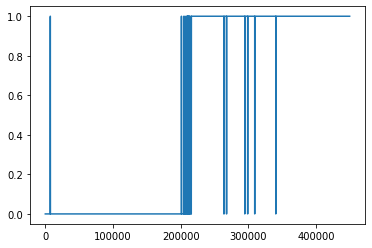

In [55]:
import matplotlib.pyplot as plt
plt.plot(y_pred)

              precision    recall  f1-score   support

         0.0       0.93      0.56      0.70    394901
         1.0       0.18      0.70      0.29     55006

    accuracy                           0.57    449907
   macro avg       0.56      0.63      0.49    449907
weighted avg       0.84      0.57      0.65    449907



In [ ]:
###  TRANSFORMER
from AnomalyDetectionMethodClass import ADMethod
data_path = './dataset/MSL'
settings = {
    'lr':1e-4,
    'num_epochs':3,
    'k':3,
    'win_size':100,
    'input_c':55,
    'output_c':55,
    'batch_size':256,
    'pretrained_model':None,
    'dataset':'MSL',
    'mode':'train', # choices=['train', 'test']
    'data_path':'./dataset/MSL',
    'model_save_path':'checkpoints',
    'anormly_ratio':1
}
method = ADMethod('transformer',settings, data_path)

method.prepare_pipeline()
method.train()
method.test()
method.results()

In [ ]:
### DEEPANT
from AnomalyDetectionMethodClass import ADMethod
data_path = './NAB/realKnownCause/ambient_temperature_system_failure.csv'
settings = {
  'SEQ_LEN': 10,
  'out_dim': 1,
  'EPOCHS': 50
}
method = ADMethod('DeepAnt',settings, data_path)

method.prepare_pipeline()
l = method.train()
p, lp = method.test()
# method.results()


import seaborn as sns
def plot_predictions(preds, threshold, bins = 80):
    sns.displot(preds, bins = bins, kde = True, height = 8, aspect = 2)
    plt.axvline(x = threshold, color = 'r', linestyle = '--', label = 'Chosen Threshold')
    plt.title('Loss Distribution')
    plt.legend()

def loss_plot(preds, threshold):
    fig = plt.figure(figsize=(15,8))
    plt.plot(preds, label = 'Loss')
    # preds.plot(figsize = (15,8), title = 'Chosen Threshold', label = 'Loss')
    plt.axhline(y = threshold, color = 'r', linestyle = '--', label = 'Chosen Threshold')
    plt.legend()
    plt.show()

def ts_plot(df, preds, threshold, alg = 'DeepAnT', range = None):
    idx = preds.loc[lambda x: x > threshold].index
    plt.figure(figsize = (20,8))
    if range is not None:
        min, max = range
        df = df[min:max]
    plt.plot(df, label = '_nolegend_')
    plt.scatter(idx, df.loc[idx], color = 'red', label = 'Detected Anomalies by DeepAnt')
    plt.title('Detected Anomalies in Time Series')
    plt.legend()
    plt.show()



import sklearn
import numpy as np
sc = sklearn.preprocessing.MinMaxScaler(feature_range=(0,1))
losses = sc.fit_transform(np.array(lp).reshape(-1, 1))
plot_predictions(losses, 0.75)
loss_plot(losses, 0.75)


import pandas as pd
df = pd.read_csv(data_path, index_col = 'timestamp', parse_dates=['timestamp'])
target_idx = method.solver.dataset.timestamp
preds_losses = pd.Series(losses.reshape((-1)), index = target_idx)
ts_plot(df, preds_losses, 0.70)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


NameError: ignored